# How does binarity change across primary mass?

Benjamin Pennell

December 24th, 2025

Max Planck Institut für Astronomie, Heidelberg

---

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
import json

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


So, we have generated different soltype cubes for three different eccentricity models

In [3]:
sc_cubes_circular = pickle.load(open("./data/2025-12-19-mdwarf_mbins_3plx_circular.pkl", "rb"))
sc_cubes_thermal = pickle.load(open("./data/2025-12-19-mdwarf_mbins_3plx_thermal.pkl", "rb"))
sc_cubes_turnover = pickle.load(open("./data/2025-12-19-mdwarf_mbins_3plx_turnover.pkl", "rb"))
sc_cube_set = [sc_cubes_circular, sc_cubes_thermal, sc_cubes_turnover]

In [46]:
t_loaded = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')
all_mdwarfs = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in tqdm(t_loaded): # we don't need every object, really 
    df = dict()
    for item in relevant_list:
        working_item = item
        if item == "mass":
            working_item = "mass_single"
        df[item] = float(row[working_item])
    all_mdwarfs.append(df)

  0%|          | 0/260095 [00:00<?, ?it/s]

and, each of these cubes were generated for ten different mass bins. The aim - see how the expected binarity changes as primary masses change

Now, the storage of each cube is as follows
- `sc_cube["data"][mass][parallax]`

We will have to do some rearranging to get it into the format that works already with the code

In [5]:
# t_loaded = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')
# all_mdwarfs = []
# relevant_list = ["parallax", "mass", "solution_type"]
# for row in tqdm(t_loaded[::100]): # we don't need every object, really 
#     df = dict()
#     for item in relevant_list:
#         working_item = item
#         if item == "mass":
#             working_item = "mass_single"
#         df[item] = float(row[working_item])
#     all_mdwarfs.append(df)
    
# percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) - 5
# masses = np.array([t["mass_single"] for t in all_mdwarfs])
# mass_lims = np.percentile(masses, percentiles)

# for i in tqdm(range(len(mass_lims))):
#     temp_catalogue = []
#     for j, obj in enumerate(memory_reduced):
#         if i == 0:
#             if obj["mass_single"] < mass_lims[0]:
#                 temp_catalogue.append(obj)
#         else:
#             if (mass_lims[i-1] < obj["mass_single"]) & (obj["mass_single"] < mass_lims[i]):
#                 temp_catalogue.append(obj)
                
def convert_to_usable(sc_cubes, mass_index):
    target_mass = sc_cubes["meta"]["reference_masses"][mass_index]
    
    out_sc_cube = {}
    out_sc_cube["data"] = sc_cubes["data"][target_mass]
    out_sc_cube["meta"] = {}
    out_sc_cube["meta"]["shape"] = sc_cubes["meta"]["shape"]
    out_sc_cube["meta"]["lambdas"] = np.array(sc_cubes["meta"]["lambdas"][mass_index])
    out_sc_cube["meta"]["periods"] = sc_cubes["meta"]["periods"]
    out_sc_cube["meta"]["parallaxes"] = sc_cubes["meta"]["parallaxes"]
    
    out_catalogue = []
    for i in range(3):
        out_catalogue = out_catalogue + sc_cubes["meta"]["memory_reduced_catalogue"][mass_index][i]

    # pull out only what we need
    memory_reduced = []
    relevant_list = ["parallax", "mass", "solution_type", "phot_g_mean_mag"]
    for row in out_catalogue: 
        df = dict()
        for item in relevant_list:
            working_item = item
            if item == "mass":
                working_item = "mass_single"
            df[item] = float(row[working_item])
        memory_reduced.append(df)
    
    return out_sc_cube, memory_reduced

In [ ]:
results = np.zeros((10, 3))
for i in range(10):
    model_cube = Sampler.create_model_cube((15,15), p_model=(4,2))
    out_sc_cube, out_catalogue = convert_to_usable(sc_cubes_circular, i)
    synthsampler = Sampler.popsampler(out_sc_cube, np.array(out_catalogue)[::3], model_cube=model_cube)
    fbs, likelihoods = synthsampler.binarity(resolution=250)
    results[i] = synthsampler.fb_estimator()

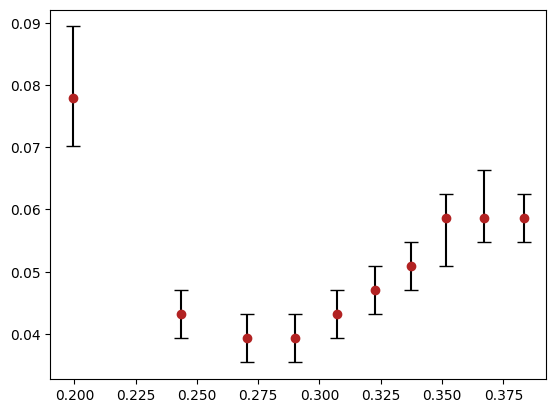

In [ ]:
plt.errorbar(sc_cubes_circular["meta"]["reference_masses"], results[:,0], yerr=(results[:,2], results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(sc_cubes_circular["meta"]["reference_masses"], results[:,0], marker='o', color='firebrick', zorder=2, label="(4,3)");

### and do it with all of them now
- three eccentricity models
- four period models
    - flat, (4,2), (4,3), (5,3)

In [6]:
sc_cubes_old = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))

In [160]:
target_mass = sc_cubes_circular["meta"]["reference_masses"][0]
    
out_sc_cube = {}
out_sc_cube["data"] = sc_cubes_circular["data"][target_mass]
out_sc_cube["meta"] = {}
out_sc_cube["meta"]["shape"] = sc_cubes_circular["meta"]["shape"]
out_sc_cube["meta"]["lambdas"] = np.array(sc_cubes_circular["meta"]["lambdas"][0])
out_sc_cube["meta"]["periods"] = sc_cubes_circular["meta"]["periods"]
out_sc_cube["meta"]["parallaxes"] = sc_cubes_circular["meta"]["parallaxes"]

out_catalogue = []
for i in range(3):
    out_catalogue = out_catalogue + sc_cubes_circular["meta"]["memory_reduced_catalogue"][0][i]

# pull out only what we need
memory_reduced = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in out_catalogue: 
    df = dict()
    for item in relevant_list:
        working_item = item
        if item == "mass":
            working_item = "mass_single"
        df[item] = float(row[working_item])
    memory_reduced.append(df)

In [157]:
np.array(out_sc_cube["meta"]["periods"]).shape

(75,)

In [158]:
np.array(sc_cubes_old["meta"]["periods"]).shape

(125,)

In [162]:
out_sc_cube, out_catalogue = convert_to_usable(sc_cubes_circular, 8)

model_cube = Sampler.create_model_cube((25,25), p_model=(1,1))
synthsampler = Sampler.popsampler(out_sc_cube, np.array(out_catalogue)[::10], model_cube=model_cube)
# working_catalogue, grids = synthsampler.binarity_precomputations()
fbs, likelihoods = synthsampler.binarity(resolution=2500, verbose=True)
print(synthsampler.fb_estimator())

model_cube = Sampler.create_model_cube((25,25), p_model=(4,1))
synthsampler = Sampler.popsampler(out_sc_cube, np.array(out_catalogue)[::10], model_cube=model_cube)
# working_catalogue_2, grids_2 = synthsampler.binarity_precomputations()
fbs, likelihoods = synthsampler.binarity(resolution=2500, verbose=True)
print(synthsampler.fb_estimator())

Reducing catalogue...
Computing grids...


  0%|          | 0/2755 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/2500 [00:00<?, ?it/s]

(np.float64(0.25126050420168067), np.float64(0.03726290516206482), np.float64(0.03418967587034816))
Reducing catalogue...
Computing grids...


  0%|          | 0/2755 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/2500 [00:00<?, ?it/s]

(np.float64(0.2255222088835534), np.float64(0.033421368547419006), np.float64(0.030732292917166865))


In [165]:
labels = ["circular"]#, "thermal"] #["circular", "thermal", "turnover"]
models = [None, (4,3)] # , (4,2), (5,3)]
results = np.zeros((len(labels), len(models), 10, 3))

pbar = tqdm(total=np.prod(results.shape[:-1]))
for i in range(results.shape[0]): # eccentricity
    sc_cubes = sc_cube_set[i]
    for j in range(results.shape[1]): # models
        model_cube = Sampler.create_model_cube((25,25), p_model=models[j])
        for k in range(results.shape[2]):
            out_sc_cube, out_catalogue = convert_to_usable(sc_cubes, k)
            synthsampler = Sampler.popsampler(out_sc_cube, np.array(out_catalogue), model_cube=model_cube)
            fbs, likelihoods = synthsampler.binarity(resolution=2500, verbose=False)
            results[i,j,k] = synthsampler.fb_estimator()
            print(synthsampler.fb_estimator())
            pbar.update(1)

  0%|          | 0/20 [00:00<?, ?it/s]

(np.float64(0.3369267707082833), np.float64(0.020744297719087645), np.float64(0.01997599039615844))
(np.float64(0.17865546218487394), np.float64(0.010756302521008398), np.float64(0.010372148859543823))
(np.float64(0.16981992797118847), np.float64(0.010756302521008398), np.float64(0.009987995198079247))
(np.float64(0.1659783913565426), np.float64(0.010372148859543823), np.float64(0.00998799519807922))
(np.float64(0.1821128451380552), np.float64(0.010756302521008398), np.float64(0.010372148859543823))
(np.float64(0.19440576230492196), np.float64(0.010756302521008398), np.float64(0.010756302521008398))
(np.float64(0.20977190876350538), np.float64(0.011140456182473002), np.float64(0.010756302521008398))
(np.float64(0.22744297719087633), np.float64(0.011524609843937578), np.float64(0.011140456182472974))
(np.float64(0.24280912364945978), np.float64(0.011524609843937605), np.float64(0.011524609843937578))
(np.float64(0.23166866746698678), np.float64(0.011140456182473002), np.float64(0.010756

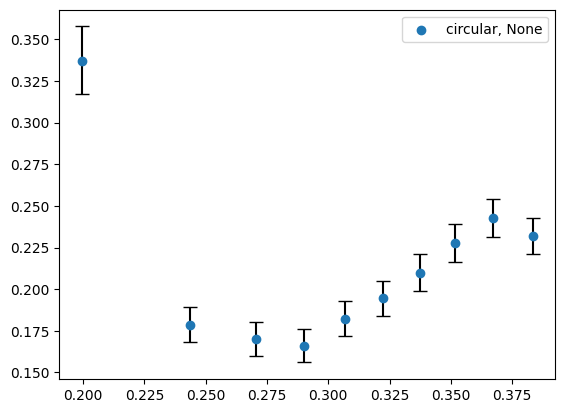

In [167]:
for i in range(results.shape[0]): # eccentricity
    label = labels[i]
    for j in range(results.shape[1]-1): # models
        p_model = models[j]
        working_results = results[i,j]
        plt.errorbar(sc_cubes_circular["meta"]["reference_masses"], working_results[:,0], yerr=(working_results[:,2], working_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
        plt.scatter(sc_cubes_circular["meta"]["reference_masses"], working_results[:,0], marker='o', zorder=2, label=f"{label}, {p_model}");

plt.legend();

so, this looks like the brown dwarf desert. cool *if* real

## cool if real

do it with synthetic data now

to start - create a bunch of datasets with the same binary fraction, see if flat binary fraction is recovered

then, do some primary mass dependant binarity and see if that's recoverable too

In [7]:
with open('./data/massive_samples.json', 'r') as fp:
    synthdata = json.load(fp)["data"][0]

In [36]:
with open('./data/massive_samples.json', 'r') as fp:
    meta = json.load(fp)["meta"]

circular, (4,2)

In [34]:
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
masses = np.array([t["mass"] for t in all_mdwarfs])
mass_lims = np.percentile(masses, percentiles)

synth_results = []
sc_cubes = sc_cubes_circular

for mass_index in tqdm(range(len(mass_lims))):
    temp_catalogue = []
    for j, obj in enumerate(synthdata):
        if mass_index == 0:
            if obj["mass"] < mass_lims[0]:
                temp_catalogue.append(obj)
        else:
            if (mass_lims[mass_index-1] < obj["mass"]) & (obj["mass"] < mass_lims[mass_index]):
                temp_catalogue.append(obj)
    
    # reduce to only mandatory objects to save on memory
    working_catalogue = []
    relevant_list = ["parallax", "mass", "solution_type"]
    for row in temp_catalogue:
        df = dict()
        for item in relevant_list:
            df[item] = float(row[item])
        working_catalogue.append(df)
    
    model_cube = Sampler.create_model_cube((15,15), p_model=(4,2))
    out_sc_cube, out_catalogue = convert_to_usable(sc_cubes, mass_index)
    synthsampler = Sampler.popsampler(out_sc_cube, working_catalogue, model_cube=model_cube)
    fbs, likelihoods = synthsampler.binarity(resolution=1000, verbose=False)
    synth_results.append(synthsampler.fb_estimator())
synth_results = np.array(synth_results)

  0%|          | 0/10 [00:00<?, ?it/s]

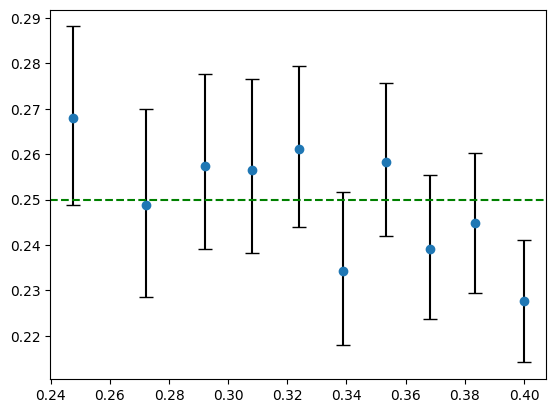

In [39]:
plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, synth_results[:,0], marker='o', zorder=2);
plt.axhline(y=0.25, c="green", linestyle="--");

In [31]:
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
masses = np.array([t["mass"] for t in all_mdwarfs])
mass_lims = np.percentile(masses, percentiles)

synth_results = []
sc_cubes = sc_cubes_circular

temp_catalogue = []
for j, obj in enumerate(synthdata):
    if (mass_lims[-2] < obj["mass"]) & (obj["mass"] < mass_lims[-1]):
        temp_catalogue.append(obj)

# reduce to only mandatory objects to save on memory
working_catalogue = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in temp_catalogue:
    df = dict()
    for item in relevant_list:
        df[item] = float(row[item])
    working_catalogue.append(df)

for i in tqdm(range(len(mass_lims))):
    model_cube = Sampler.create_model_cube((15,15), p_model=(4,2))
    out_sc_cube, out_catalogue = convert_to_usable(sc_cubes, i)
    synthsampler = Sampler.popsampler(out_sc_cube, working_catalogue, model_cube=model_cube)
    fbs, likelihoods = synthsampler.binarity(resolution=1000, verbose=False)
    synth_results.append(synthsampler.fb_estimator())
synth_results = np.array(synth_results)

  0%|          | 0/10 [00:00<?, ?it/s]

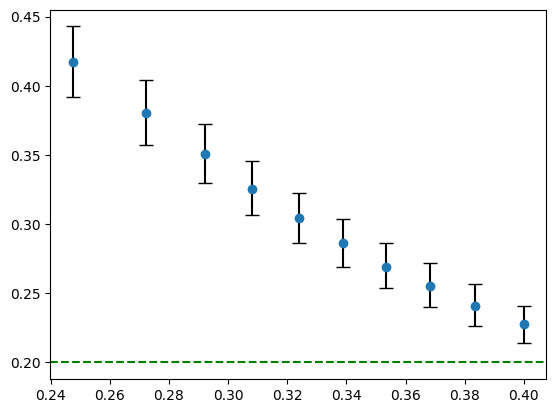

In [ ]:
plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, synth_results[:,0], marker='o', zorder=2);
plt.axhline(y=0.25, c="green", linestyle="--");

In [8]:
sc_cubes_singular = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))

Reducing catalogue...
Computing grids...


  0%|          | 0/25000 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/2500 [00:00<?, ?it/s]

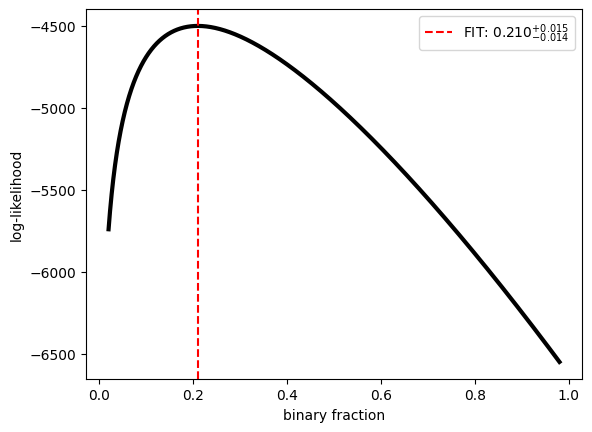

In [31]:
working_catalogue = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in synthdata[::10]:
    df = dict()
    for item in relevant_list:
        df[item] = float(row[item])
    working_catalogue.append(df)

model_cube = Sampler.create_model_cube((25,25), p_model=(4,2))
synthsampler = Sampler.popsampler(sc_cubes_singular, working_catalogue, model_cube=model_cube)
fbs, likelihoods = synthsampler.binarity(resolution=2500, verbose=True)
synthsampler.fb_likelihood()

In [10]:
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) - 5
masses = np.array([t["mass"] for t in all_mdwarfs])
mass_lims = np.percentile(masses, percentiles)

synth_results = []
sc_cubes = sc_cubes_circular

In [ ]:
for i in tqdm(range(len(mass_lims))):
    temp_catalogue = []
    for j, obj in enumerate(synthdata):
        if i == 0:
            if obj["mass"] < mass_lims[0]:
                temp_catalogue.append(obj)
        else:
            if (mass_lims[i-1] < obj["mass"]) & (obj["mass"] < mass_lims[i]):
                temp_catalogue.append(obj)
    
    # reduce to only mandatory objects to save on memory
    working_catalogue = []
    relevant_list = ["parallax", "mass", "solution_type"]
    for row in temp_catalogue:
        df = dict()
        for item in relevant_list:
            df[item] = float(row[item])
        working_catalogue.append(df)
    
    model_cube = Sampler.create_model_cube((25,25), p_model=(4,2))
    synthsampler = Sampler.popsampler(sc_cubes_singular, working_catalogue, model_cube=model_cube)
    fbs, likelihoods = synthsampler.binarity(resolution=2500, verbose=False)
    synth_results.append(synthsampler.fb_estimator())
synth_results = np.array(synth_results)

  0%|          | 0/10 [00:00<?, ?it/s]

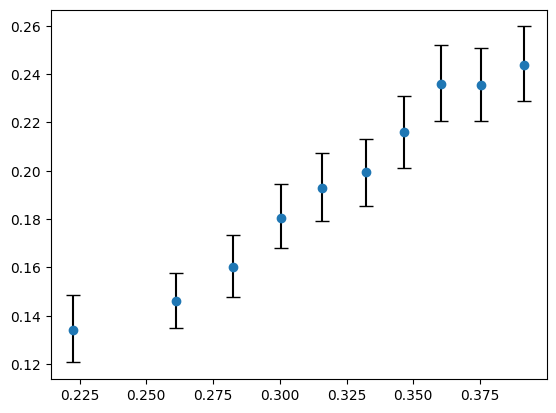

In [33]:
plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, synth_results[:,0], marker='o', zorder=2);

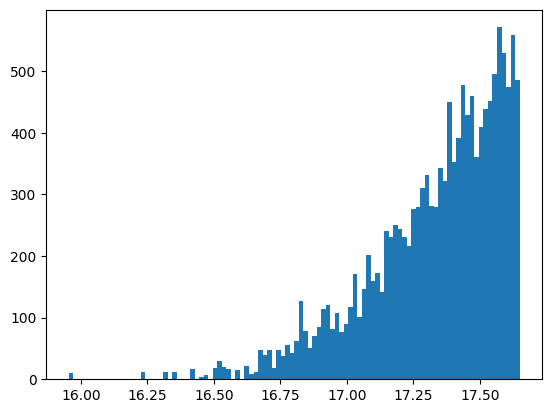

In [58]:
temp_catalogue = []
for j, obj in enumerate(synthdata):
    if obj["mass"] < mass_lims[0]:
        temp_catalogue.append(obj)
temp_catalogue = np.array(temp_catalogue)

plt.hist([t["phot_g_mean_mag"] for t in temp_catalogue], bins=100);

In [59]:
dataset = temp_catalogue
soltypes = np.array([d["solution_type"] for d in dataset])
rates = [len(dataset[soltypes == soltype])/len(dataset)*100 for soltype in [0,5,7,9,12]]
grid = [
    rates,
    [int(grp/100*len(dataset)) for grp in rates]
]
row_labels = ["Rate (%)", "Counts"]
col_labels = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
pd.DataFrame(grid, index=row_labels, columns=col_labels)

,low RUWE,high RUWE,Acceleration,Jerk,Full Orbit
Rate (%),97.469259,2.237632,0.114384,0.0,0.178725
Counts,13634.000000,313.000000,16.000000,0.0,25.000000


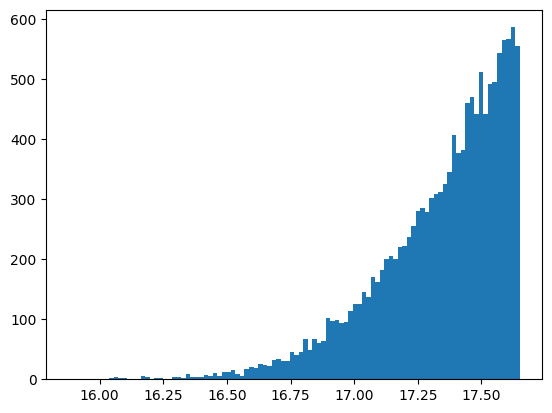

In [11]:
out_sc_cube, out_catalogue = convert_to_usable(sc_cubes_circular, 0)

temp_catalogue = []
for j, obj in enumerate(out_catalogue):
    if obj["mass"] < mass_lims[0]:
        temp_catalogue.append(obj)
temp_catalogue = np.array(temp_catalogue)

plt.hist([t["phot_g_mean_mag"] for t in temp_catalogue], bins=100);

In [57]:
dataset = temp_catalogue
soltypes = np.array([d["solution_type"] for d in dataset])
rates = [len(dataset[soltypes == soltype])/len(dataset)*100 for soltype in [0,5,7,9,12]]
grid = [
    rates,
    [int(grp/100*len(dataset)) for grp in rates]
]
row_labels = ["Rate (%)", "Counts"]
col_labels = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
pd.DataFrame(grid, index=row_labels, columns=col_labels)

,low RUWE,high RUWE,Acceleration,Jerk,Full Orbit
Rate (%),92.571885,7.282893,0.094394,0.029044,0.021783
Counts,12749.000000,1003.000000,13.000000,4.000000,3.000000


In [76]:
mcube = out_sc_cube["data"][list(out_sc_cube["data"].keys())[0]][:,:,0]

In [77]:
scube = sc_cubes_singular["data"][list(sc_cubes_singular["data"].keys())[0]][:,:,0]

In [78]:
mcube.sum()/np.prod(mcube.shape)

np.float64(243.93180952380953)

In [79]:
scube.sum()/np.prod(scube.shape)

np.float64(240.26784)

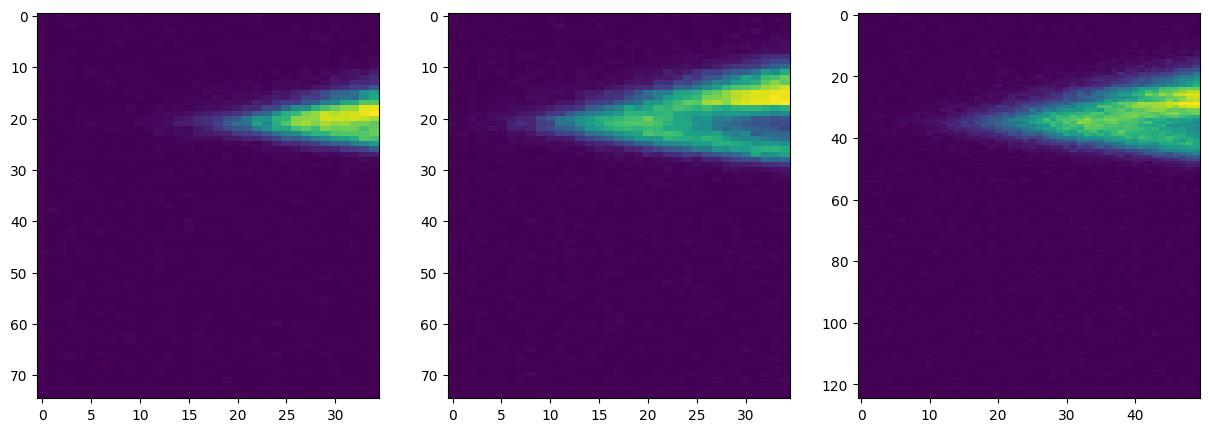

In [16]:
plxdex = 1
soldex = 1
out_sc_cube_0, _ = convert_to_usable(sc_cubes, 0)
out_sc_cube_1, _ = convert_to_usable(sc_cubes, -1)

fig, axs = plt.subplots(1,3, figsize=(15,5))

cb = axs[0].imshow(out_sc_cube_0["data"][list(out_sc_cube_0["data"].keys())[plxdex]][:,:,soldex]/250, aspect="auto");
cb = axs[1].imshow(out_sc_cube_1["data"][list(out_sc_cube_1["data"].keys())[plxdex]][:,:,soldex]/250, aspect="auto");
axs[2].imshow(sc_cubes_singular["data"][list(sc_cubes_singular["data"].keys())[plxdex]][:,:,soldex]/250, aspect="auto");
#plt.colorbar(cb)

# For realsies

In [50]:
def mass_binned_data(sc_cubes, catalogue, mass_binned=False, p_model=(4,2), model_cube_size=(15,15)):
    percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    masses = np.array([t["mass"] for t in all_mdwarfs])
    mass_lims = np.percentile(masses, percentiles)

    synth_results = []

    for mass_index in tqdm(range(len(mass_lims))):
        temp_catalogue = []
        for _, obj in enumerate(catalogue):
            if mass_index == 0:
                if obj["mass"] < mass_lims[0]:
                    temp_catalogue.append(obj)
            else:
                if (mass_lims[mass_index-1] < obj["mass"]) & (obj["mass"] < mass_lims[mass_index]):
                    temp_catalogue.append(obj)
        
        # reduce to only mandatory objects to save on memory
        working_catalogue = []
        relevant_list = ["parallax", "mass", "solution_type"]
        for row in temp_catalogue:
            df = dict()
            for item in relevant_list:
                df[item] = float(row[item])
            working_catalogue.append(df)
        
        model_cube = Sampler.create_model_cube(model_cube_size, p_model=p_model)
        out_sc_cube = sc_cubes
        if mass_binned:
            out_sc_cube, _ = convert_to_usable(sc_cubes, mass_index)
        synthsampler = Sampler.popsampler(out_sc_cube, working_catalogue, model_cube=model_cube)
        _, _ = synthsampler.binarity(resolution=1000, verbose=False)
        synth_results.append(synthsampler.fb_estimator())
    synth_results = np.array(synth_results)
    return synth_results

def generate_plot(synth_results, target_fb=None):
    plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
    plt.scatter(mass_lims, synth_results[:,0], marker='o', zorder=2);
    if target_fb is not None:
        plt.axhline(y=target_fb, c="green", linestyle="--");

what we had before

  0%|          | 0/10 [00:00<?, ?it/s]

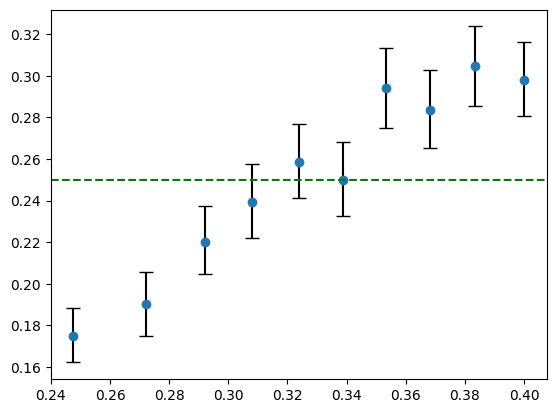

In [44]:
synth_results = mass_binned_data(sc_cubes_singular, synthdata, mass_binned=False, p_model=(4,2))
generate_plot(synth_results, target_fb=0.25)

and with the mass-binned version

  0%|          | 0/10 [00:00<?, ?it/s]

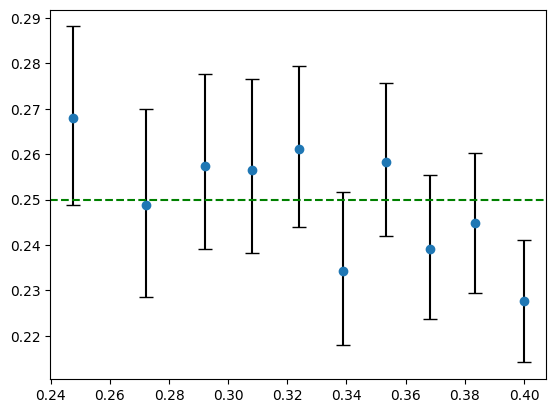

In [43]:
synth_results = mass_binned_data(sc_cubes_circular, synthdata, mass_binned=True, p_model=(4,2))
generate_plot(synth_results, target_fb=0.25)

and on the real data

In [63]:
result_set = []
p_models = [(4,1.3), (4,2), (4,3), (5,2)]
for i, sc_cubes in enumerate(sc_cube_set):
    result_set.append([])
    for p_model in p_models:
        synth_results = mass_binned_data(sc_cubes, all_mdwarfs, mass_binned=True, p_model=p_model)
        result_set[i].append(synth_results)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

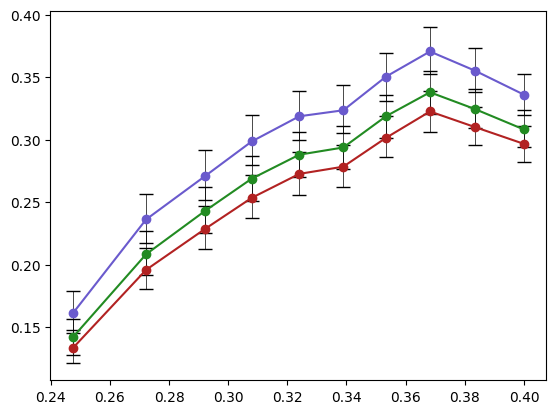

In [69]:
cols = ['firebrick', 'slateblue', 'forestgreen']
markers = ['o', '^', 's', 'X']
for i in range(3):
    for j in range(1):
        synth_results = result_set[i][j]
        plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1, linewidth=0.5);
        plt.plot(mass_lims, synth_results[:,0], marker=markers[j], color=cols[i], zorder=2); 

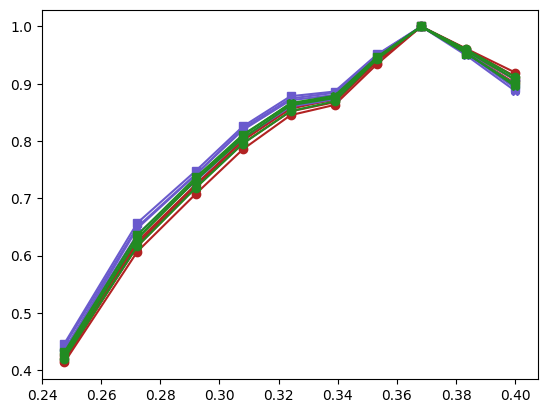

In [68]:
cols = ['firebrick', 'slateblue', 'forestgreen']
markers = ['o', '^', 's', 'X']
for i in range(3):
    for j in range(4):
        synth_results = result_set[i][j]
        #plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1, linewidth=0.5);
        plt.plot(mass_lims, synth_results[:,0]/np.max(synth_results[:,0]), marker=markers[j], color=cols[i], zorder=2); 